In [1]:
#  Required imports

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from matplotlib import cm, pyplot as plt
from   scipy import stats

print("Importing third party libraries")
import dill as pickle
import tensorflow as tf

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Inputs config

target_observable = "Dphi_j_j"  # "Dy_j_j" # "m_jj" # "Dphi_j_j"

cHWB_vals  = [-4.0, -2.0, 0.0, 2.0, 4.0]      #  [-4.0, -2.0, 0.0, 2.0, 4.0]   #  [0.0]
cWtil_vals = [-0.4, -0.2, 0.0, 0.2, 0.4]      #  [-0.4, -0.2, 0.0, 0.2, 0.4]   #  [0.0, 0.4]

def get_input_fname (cHWB, cWtil) :
    cHWB_str  = f"{cHWB :.1f}".replace("-","m").replace(".","p")
    cWtil_str = f"{cWtil:.1f}".replace("-","m").replace(".","p")
    if (cHWB == 0) and (cWtil == 0) :
        return "../Data/SM_EWK_500k_rivet_output.pickle"
    if (cHWB == 0) :
        return f"../Data/cWtil_{cWtil_str}_full_400k_rivet_output.pickle"
    return f"../Data/cHWB_{cHWB_str}_cWtil_{cWtil_str}_full_200k_rivet_output.dat"


In [3]:
#  Model config

output_size_per_stage     = 25
max_epochs                = 1000
batch_sizes               = [100]
early_stopping_patience   = 4
early_stopping_min_delta  = 0
validation_split          = 0.5
test_split                = 0.

white_linear_fraction_data_space   = .9       # Dphi_j_j is 0.8, otherwise 0.2
white_linear_fraction_latent_space = 0.       # Keep 0, otherwise we get hard boundaries on latent space
whitening_num_points               = 200

learning_rate  = 1e-3        # 0.01 for SGD or 0.001 otherwise
optimiser      = "adam"      # SGD, Adam or AdaDelta
load_models    = False
load_whitening = False
save_plots     = True


In [4]:

class whitening_method :
    def __init__ (self, func_form, alpha=0., beta=0., gamma=0., load_file=None, save_file=None, load_model_dir=None, save_model_dir=None) :
        assert func_form in ["step", "gaus"]
        self.func_form      = func_form
        self.alpha          = alpha
        self.beta           = beta
        self.gamma          = gamma
        self.load_file      = load_file
        self.save_file      = save_file
        self.load_model_dir = load_model_dir
        self.save_model_dir = save_model_dir

whitening_gaus = whitening_method("gaus",          load_file=".white_funcs_paper_gaus.pickle", save_file=".white_funcs_paper_gaus.pickle", load_model_dir=".EWK_density_model_paper_gaus", save_model_dir=".EWK_density_model_paper_gaus")
whitening_step = whitening_method("step", 4, 3, 1, load_file=".white_funcs_paper_step.pickle", save_file=".white_funcs_paper_step.pickle", load_model_dir=".EWK_density_model_paper_step", save_model_dir=".EWK_density_model_paper_step")
whitening_methods = [whitening_step]


In [5]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = [obs for obs in observable_limits if obs != target_observable] 

int_observables = ["N_jets", "N_gap_jets"]

observables_order = [target_observable]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [6]:
#  Plots config
#  pT_ll
'''intervals = []

minor_intervals = []

x_prime = 500'''


#  Plots config
#  Dphi_jj

intervals = [[-np.pi, r"$-\pi$"], [-3.*np.pi/4., r"$-\frac{3\pi}{4}$"], [-np.pi/2., r"$-\frac{\pi}{2}$"],
             [-np.pi/4., r"$-\frac{\pi}{4}$"], [0, "$0$"], [np.pi/4., r"$\frac{\pi}{4}$"],
             [np.pi/2., r"$\frac{\pi}{2}$"], [3.*np.pi/4., r"$\frac{3\pi}{4}$"], [np.pi, r"$\pi$"]]

minor_intervals = [(i-16.)*np.pi/16. for i in range(32) if i % 4 != 0]

x_prime = 0.8


#  Plots config
#  m_jj

'''intervals = []

minor_intervals = []

x_prime = 2500'''


#  Plots config
#  Dy_j_j

'''intervals = []

minor_intervals = []

x_prime = 4.'''


'intervals = []\n\nminor_intervals = []\n\nx_prime = 4.'

In [7]:
#  Load and format the data
#

data_tables = {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        input_fname = get_input_fname (cHWB, cWtil)
        print(f"Creating data table for cHWB={cHWB} and cWtil={cWtil}")
        print(f" -- events from file {input_fname}")
        data = DataTable(input_fname)
        print(f" -- Table created with {data.get_num_events()} events")
        for observable, limits in observable_limits.items() :
            print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
            data.filter(observable, limits[0], limits[1])
            print(f" -- {data.get_num_events()} events survived")
        for observable in remove_observables :
            print(f" -- removing observable {observable}")
            data.remove_column(observable)
        print(" -- ordering observables")
        data.reorder(*observables_order)
        data.print_summary()
        data_tables [(cHWB, cWtil)] = data
    

Creating data table for cHWB=-4.0 and cWtil=-0.4
 -- events from file ../Data/cHWB_m4p0_cWtil_m0p4_full_200k_rivet_output.dat
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 130332 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 130259 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 130259 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 128561 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 126644 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 126644 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 126644 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 126644 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 126614 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 126501 events survived
 -- filtering observable Dy_j_j bet

 -- 126217 events survived
 -- removing observable m_ll
 -- removing observable pT_ll
 -- removing observable theta_ll
 -- removing observable rap_ll
 -- removing observable m_jj
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable Dy_j_j
 -- removing observable N_jets
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | Dphi_j_j | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 0.7261         |
    +-------------------------+

* Number of events       : 126217
* Cross section per event: 0.252818
* Total cross section   

 -- 131742 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 131738 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 131738 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130007 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128133 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128133 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128133 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128133 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128110 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 128003 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128003 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 128003 events survived
 -- filtering observable N_jets between 2 and 5
 -- 128003 e

 -- 264467 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 264437 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 264437 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 261020 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 257387 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 257387 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 257387 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 257387 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 257342 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 257153 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 257153 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 257153 events survived
 -- filtering observable N_jets between 2 and 5
 -- 257153 e

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132875 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132825 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132825 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 131078 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129267 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129267 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129267 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129267 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 129242 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 129149 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 129149 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- removing observable pT_j2
 -- removing observable Dy_j_j
 -- removing observable N_jets
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | Dphi_j_j | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.4501         |
    +-------------------------+

* Number of events       : 129276
* Cross section per event: 0.253305
* Total cross section    : 0.36731679652102495 +/- 0.0010227370724427642 pb
Creating data table for cHWB=2.0 and cWtil=0.4
 -- events from file ../Data/cHWB_2p0_cWtil_0p4_full_200k_rivet_output.dat
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132810 events survived
 -- filtering ob

 -- 129315 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129315 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129315 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129315 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 129290 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 129189 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 129189 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 129189 events survived
 -- filtering observable N_jets between 2 and 5
 -- 129189 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 129189 events survived
 -- removing observable m_ll
 -- removing observable pT_ll
 -- removing observable theta_ll
 -- removing observable rap_ll
 -- removing observable m_jj
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing ob

In [8]:

for white_meth in whitening_methods :
    
    whitening_funcs = None
    if (load_whitening) and (type(white_meth.load_file) != type(None) and (os.path.isfile(white_meth.load_file))) :
        print(f"Loading whitening functions from file {white_meth.load_file}")
        whitening_funcs = pickle.load(open(white_meth.load_file, "rb"))

    axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data_space, white_linear_fraction_latent_space] for key in data.keys]

    white_meth.observable_data, white_meth.weight_data, white_meth.white_data_to_fit = {}, {}, {}
    for cHWB in cHWB_vals :
        for cWtil in cWtil_vals :
            data = data_tables [(cHWB, cWtil)]
            #  Seperate data from weights
            white_meth.observable_data [(cHWB, cWtil)], white_meth.weight_data [(cHWB, cWtil)] = data.get_observables_and_weights()
            #  Whiten data
            print(f"Whitening dataset for {(cHWB, cWtil)}")
            white_meth.white_data_to_fit[(cHWB, cWtil)], whitening_funcs = whiten_axes (white_meth.observable_data[(cHWB, cWtil)], data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights(), 
                                                                                        func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)
        
    white_meth.white_data_to_test = {k:i[:int(test_split*len(i))] for k,i in white_meth.white_data_to_fit.items()}
    white_meth.white_data_to_fit  = {k:i[int(test_split*len(i)):] for k,i in white_meth.white_data_to_fit.items()}
    
    if len(intervals) > 0 :
        white_meth.white_intervals = whiten_axes (np.array([[i[0]] for i in intervals]), data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in intervals], 
                                                  func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_intervals = []
    
    if len(minor_intervals) > 0 :
        white_meth.white_minor_intervals = whiten_axes (np.array([[i] for i in minor_intervals]), data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in minor_intervals], 
                                                        func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_minor_intervals = []
    
    if type(white_meth.save_file) != type(None) :
        print(f"Saving whitening functions to file {white_meth.save_file}")
        pickle.dump(whitening_funcs, open(white_meth.save_file, "wb"))
        

Whitening dataset for (-4.0, -0.4)
Whitening dataset for (-4.0, -0.2)
Whitening dataset for (-4.0, 0.0)
Whitening dataset for (-4.0, 0.2)
Whitening dataset for (-4.0, 0.4)
Whitening dataset for (-2.0, -0.4)
Whitening dataset for (-2.0, -0.2)
Whitening dataset for (-2.0, 0.0)
Whitening dataset for (-2.0, 0.2)
Whitening dataset for (-2.0, 0.4)
Whitening dataset for (0.0, -0.4)
Whitening dataset for (0.0, -0.2)
Whitening dataset for (0.0, 0.0)
Whitening dataset for (0.0, 0.2)
Whitening dataset for (0.0, 0.4)
Whitening dataset for (2.0, -0.4)
Whitening dataset for (2.0, -0.2)
Whitening dataset for (2.0, 0.0)
Whitening dataset for (2.0, 0.2)
Whitening dataset for (2.0, 0.4)
Whitening dataset for (4.0, -0.4)
Whitening dataset for (4.0, -0.2)
Whitening dataset for (4.0, 0.0)
Whitening dataset for (4.0, 0.2)
Whitening dataset for (4.0, 0.4)
Saving whitening functions to file .white_funcs_paper_step.pickle


In [9]:
#  Weight all training points equally
#

for white_meth in whitening_methods :
    white_meth.weights_to_test = {k:i[:int(test_split*len(i))]/np.sum(i[:int(test_split*len(i))]) for k,i in white_meth.weight_data.items()}
    white_meth.weights_to_fit  = {k:i[int(test_split*len(i)):]/np.sum(i[int(test_split*len(i)):]) for k,i in white_meth.weight_data.items()}
    cHWB_sf, cWtil_sf = np.max(np.fabs(cHWB_vals)), np.max(np.fabs(cWtil_vals))
    cHWB_sf, cWtil_sf = 1./cHWB_sf if (cHWB_sf>0) else 1., 1./cWtil_sf if (cWtil_sf>0) else 1.
    white_meth.weights_to_fit_2 = {k:(1+np.fabs(k[0])*cHWB_sf)*(1+np.fabs(k[1])*cWtil_sf)*i/np.sum(i) for k,i in white_meth.weights_to_fit.items()}
    

In [10]:
#  Save numbers required to plot whitening function
#

for white_meth in whitening_methods :

    alpha, beta , gamma      = white_meth.alpha, white_meth.beta, white_meth.gamma
    axmin, axmax, ax_npoints = observable_limits[target_observable][0], observable_limits[target_observable][1], whitening_num_points
    ax_scan_points           = np.linspace(axmin, axmax, 1+ax_npoints)
    data_frac_constant       = white_linear_fraction_data_space
    gauss_frac_constant      = white_linear_fraction_latent_space
    dataset   = white_meth.observable_data[(0,0)][:,0]
    weights   = white_meth.weights_to_fit [(0,0)]
    ds_and_w  = np.array([(x,w) for x, w in zip(dataset, weights) if (x>axmin and x<axmax)])
    dataset, weights = [x[0] for x in ds_and_w], [x[1] for x in ds_and_w]
    weights   = weights / np.sum(weights)
    func_form = white_meth.func_form
        
    print("Getting data c.d.f.")
    data_cdf = []
    for A in ax_scan_points :
        sys.stdout.write(f"\rScan point is: {A:.4f}  ----------")
        data_cdf.append(np.sum([w for x,w in zip(dataset, weights) if x < A]))
    data_cdf     = np.array(data_cdf)
    constant_cdf = (ax_scan_points - axmin) / (axmax - axmin)
    combined_cdf = data_frac_constant*constant_cdf + (1-data_frac_constant)*data_cdf
    
    white_meth.ax_scan_points = ax_scan_points
    white_meth.cdf_data, white_meth.cdf_data_linear, white_meth.cdf_x = data_cdf, constant_cdf, combined_cdf

    print("\nGetting latent c.d.f.")
    if func_form == "step" :
        white_space_x   = np.linspace(-5, 5, 201)
        Smooth_step_y   = 1. / (1 + np.exp((white_space_x-beta)*alpha-gamma)) / (1 + np.exp(-(white_space_x+beta)*alpha-gamma))
        white_meth.white_space_y = Smooth_step_y
        Smooth_step_cdf = np.array([np.sum(Smooth_step_y[:i+1]) for i in range(len(Smooth_step_y))])
        Smooth_step_cdf = Smooth_step_cdf / Smooth_step_cdf[-1]
        Smooth_step_cdf[0] = 0.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Smooth_step_cdf
        white_meth.cdf_target    = Smooth_step_cdf
        white_meth.white_space_x = white_space_x
    else :
        white_space_x   = np.linspace(-5, 5, 201)
        white_meth.white_space_y = stats.norm.pdf(white_space_x)
        Gauss_cdf       = stats.norm.cdf(white_space_x)
        Gauss_cdf[0], Gauss_cdf[-1] = 0., 1.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Gauss_cdf 
        white_meth.cdf_target    = Gauss_cdf
        white_meth.white_space_x = white_space_x
        
    white_meth.white_space_x = white_space_x
    white_meth.cdf_latent_linear, white_meth.cdf_u = constant_cdf, white_space_cdf
    
    print("Done")


Getting data c.d.f.
Scan point is: 3.1416  -----------
Getting latent c.d.f.
Done


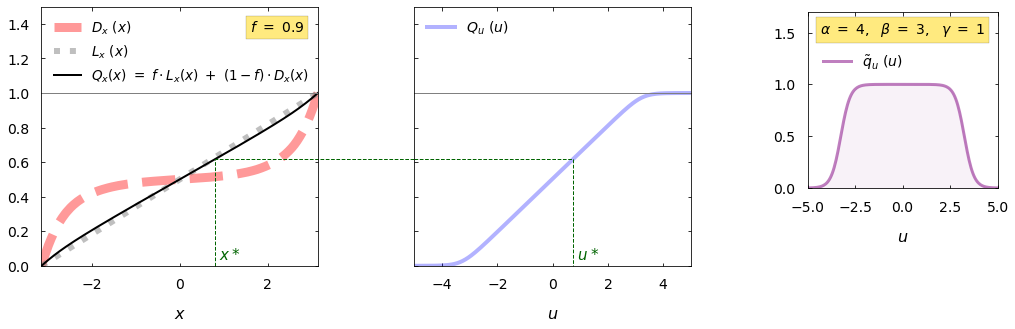

In [11]:
#  Plot whitening functions
#

for white_meth in whitening_methods :
    y_prime = np.interp(x_prime, white_meth.ax_scan_points, white_meth.cdf_x        )
    u_prime = np.interp(y_prime, white_meth.cdf_u         , white_meth.white_space_x)
    
    fig    = plt.figure(figsize=(14., 0.8*4.5))
    ax     = fig.add_axes([0.01, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.ax_scan_points
    ax.plot(plot_x, white_meth.cdf_data        , "-", linestyle="--", lw=9, c="r"   , alpha=0.4, label="$D_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_data_linear , "-", linestyle=":" , lw=6, c="grey", alpha=0.5, label="$L_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_x           , "-", linestyle="-" , lw=2, c="k"   , label="$Q_x(x) ~=~ f\cdot L_x(x) ~+~ (1-f)\cdot D_x(x)$")
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=13.5, frameon=False)
    ax.plot([x_prime, x_prime, 2*plot_x[-1]-plot_x[0]], [0, y_prime, y_prime], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(x_prime, 0.02, " $x*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    ax.text(0.95, 0.95, f"$f~=~{white_linear_fraction_data_space:.1f}$", ha="right", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    ax     = fig.add_axes([0.38, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.white_space_x
    ax.plot(plot_x, white_meth.cdf_u, "-", linestyle="-" , lw=4, c="b", label="$Q_u~(u)$", alpha=0.3)
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.get_yaxis().set_ticklabels([])
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=14, frameon=False)
    ax.plot([plot_x[0], u_prime, u_prime], [y_prime, y_prime, 0], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(u_prime, 0.02, " $u*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    
    ax     = fig.add_axes([0.77, 0.31, 0.22*12./14., 0.68])
    ax.plot(white_meth.white_space_x, white_meth.white_space_y, "-", linestyle="-", lw=3, c="purple", label=r"${\tilde q}_u~(u)$", alpha=0.5)
    ax.fill_between(white_space_x, np.zeros(shape=white_meth.white_space_x.shape), white_meth.white_space_y, color="purple", alpha=0.05)
    ax.set_xlim([white_space_x[0], white_space_x[-1]])
    maxy = 1.7*np.max(white_meth.white_space_y)
    ax.set_ylim([0        , maxy])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc=(0.05, 0.63), fontsize=14, frameon=False) 
    ax.text(0.5, 0.95, r"$\alpha~="+f"~{white_meth.alpha:.0f}"+r",~~\beta ~="+f"~{white_meth.beta :.0f}"+r",~~\gamma~="+f"~{white_meth.gamma:.0f}$", ha="center", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    plt.subplots_adjust(wspace=0.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/whitening_method/projection_functions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()

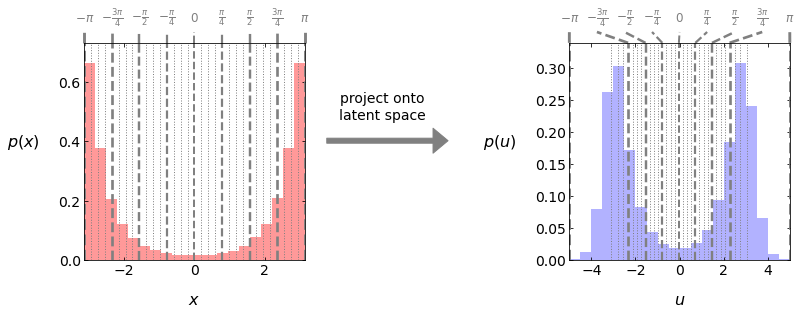

In [12]:
#  Weight all training points equally
#  -  and plot original / laten distributions
#

for white_meth in whitening_methods :
    fig = plt.figure(figsize=(10, 4))

    ax   = fig.add_subplot(1, 2, 1)
    bins = np.linspace(observable_limits[target_observable][0], observable_limits[target_observable][1], 21)
    vals, _, _ = ax.hist(white_meth.observable_data[(0,0)], weights=white_meth.weight_data[(0,0)], bins=bins, density=True, color="r", alpha=0.4)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(x)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    
    for idx, i in enumerate(intervals) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(i[0], linestyle="--", c="grey", linewidth=lw)
        ax.text(i[0], 1.1*hmax, i[1], c="grey", fontsize=12, ha="center")
        ax.plot([i[0], i[0]], [hmax, 1.05*hmax], linestyle="--", c="grey", linewidth=lw, clip_on=False)
    
    for i in minor_intervals :
        ax.axvline(i, linestyle=":", c="grey", linewidth=1.)
        
    ax   = fig.add_subplot(1, 2, 2)
    edge = np.max(np.fabs(white_meth.white_data_to_fit[(0,0)]))
    bins = np.linspace(-edge, edge, 21)
    vals , _, _ = ax.hist(white_meth.white_data_to_fit[(0,0)], weights=white_meth.weights_to_fit[(0,0)], bins=bins, density=True, color="b", alpha=0.3)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([np.min(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]])), np.max(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]]))])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(u)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    
    for idx, (i, wi) in enumerate(zip(intervals, white_meth.white_intervals)) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(wi[0], linestyle="--", c="grey", linewidth=lw)
        xlo, xhi, xrange = bins[0], bins[-1], bins[-1] - bins[0]
        label_pos        = xlo + xrange*(idx/(len(intervals)-1.)), 1.1*hmax, 1.05*hmax
        line_pos         = wi[0], hmax
        ax.text(label_pos[0], label_pos[1], i[1], c="grey", fontsize=12, ha="center")
        ax.plot([line_pos[0], label_pos[0]], [line_pos[1], label_pos[2]], linestyle="--", c="grey", linewidth=lw, clip_on=False)
        
    for wi in white_meth.white_minor_intervals :
        ax.axvline(wi, linestyle=":", c="grey", linewidth=1.)
        
    ax.text(-0.85, 0.65, "project onto\nlatent space", transform=ax.transAxes, ha="center", fontsize=14)
    
    ax.annotate("", xy=(-0.55, 0.55), xycoords  ="axes fraction",
                xytext=(-1.1 , 0.55), textcoords="axes fraction",
                arrowprops=dict(width=5, headwidth=25, headlength=15, facecolor="grey", edgecolor="grey"))
    
    plt.subplots_adjust(wspace=1.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/whitening_method/projection_distributions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()
    

In [13]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

def plot_mixture_model (savefig=None, log=False) :

    colours   = cm.get_cmap('brg', output_size_per_stage)   # 'hsv'
    newcolors = colours(np.linspace(0, 1, output_size_per_stage))
    x         = np.linspace(-6, 6, 241)
    bins      = np.linspace(-6, 6, 61)

    for white_meth in whitening_methods :

        fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        density_model = white_meth.density_model

        params = density_model.likelihood_models[0].get_gauss_params([[0,0]])[0]
        fracs  = params[:output_size_per_stage]
        means  = params[output_size_per_stage:2*output_size_per_stage]
        sigmas = params[2*output_size_per_stage:3*output_size_per_stage]
        
        print("fracs", fracs)
        print("means", means)
        print("sigmas", sigmas)

        ds, weights = white_meth.white_data_to_fit[(0,0)][:,0], white_meth.weights_to_fit[(0,0)]

        y1, int1 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals1, _, _     = ax0.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events ($c_{HWB}=0,~{\tilde c}_W=0$)")
        for i in range(output_size_per_stage) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y1   = y1 + yp
            int1 = int1 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax0.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax0.plot(x, y1, c="k", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~c_{HWB}=0,~{\tilde c}_W=0~)$")

        ax0.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax0.set_ylabel("$p(u)$", fontsize=16, labelpad=45, rotation=0)
        ax0.legend(loc="upper left", frameon=False, fontsize=14)

        rat_x, rat_y, rat_ey = [], [], []
        for idx, b in enumerate(bins) :
            rat_x.append(b)
            if (idx==0) or (idx==len(bins)-1) : continue
            rat_x.append(b)
        for y, ey in zip(hvals1/int1 - 1, frac_errors*hvals1/int1) :
            rat_y .append(y )
            rat_y .append(y )
            rat_ey.append(ey)
            rat_ey.append(ey)
        rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)

        ax2.axhline(0, linestyle="--", c="k", linewidth=3)
        ax2.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax2.set_yticks([-0.1, 0, 0.1])
        ax2.yaxis.set_ticklabels(["$-10\%$", "$0$", "$+10\%$"])
        ax2.plot(rat_x, rat_y, "-", c="darkgrey")
        ax2.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="darkgrey", alpha=0.5)
        ax2.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax2.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax2.set_ylabel(r"$\frac{p(u)~-~p_\phi(u)}{p_\phi(u)}$", fontsize=21, labelpad=70, rotation=0)
        ax2.set_ylim  ([-0.15, 0.15])

        params = density_model.likelihood_models[0].get_gauss_params([(0,0.4)])[0]
        fracs  = params[:output_size_per_stage]
        means  = params[output_size_per_stage:2*output_size_per_stage]
        sigmas = params[2*output_size_per_stage:3*output_size_per_stage]
        
        print("alt fracs", fracs)
        print("alt means", means)
        print("alt sigmas", sigmas)

        ds, weights = white_meth.white_data_to_fit[(0.0,0.4)][:,0], white_meth.weights_to_fit[(0.0,0.4)]
        
        y2, int2 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals2, _, _     = ax1.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events ($c_{HWB}=0,~{\tilde c}_W=0.4$)")
        for i in range(output_size_per_stage) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y2   = y2 + yp
            int2 = int2 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax1.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax1.plot(x, y1, c="k"   , linewidth=3, linestyle="--")
        ax1.plot(x, y2, c="grey", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~c_{HWB}=0,~{\tilde c}_W=0.4~)$")

        ax1.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax1.legend(loc="upper left", frameon=False, fontsize=14)

        rat_y2, rat_ey2, rat_1_over_2, rat_data = [], [], [], []
        for y, ey, f, f_data in zip(hvals2/int2 - 1, frac_errors*hvals2/int2, int1/int2 - 1, hvals1/hvals2 - 1) :
            rat_y2      .append(y )
            rat_y2      .append(y )
            rat_ey2     .append(ey)
            rat_ey2     .append(ey)
            rat_1_over_2.append(f )
            rat_1_over_2.append(f )
            rat_data    .append(f_data)
            rat_data    .append(f_data)
        rat_y2, rat_ey2, rat_data = np.array(rat_y2), np.array(rat_ey2), np.array(rat_data)

        ax3.axhline(0    , linestyle="--", c="grey", linewidth=3)
        ax3.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax3.plot(rat_x, rat_y2  , "-" , c="darkgrey")
        #ax3.plot(rat_x, rat_data, "-" , c="blue"    )
        ax3.fill_between(rat_x, rat_y2-rat_ey2, rat_y2+rat_ey2, color="darkgrey", alpha=0.5)
        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax3.set_ylim  ([-0.15, 0.15])

        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)

        ax0.set_xlim([x[0], x[-1]])
        ax1.set_xlim([x[0], x[-1]])
        hmax   = np.max([np.max(hvals1), np.max(hvals2)])
        hmin   = np.min([np.min([v for v in hvals1 if v > 0]), np.min([v for v in hvals2 if v > 0])])
        hrange = hmax - hmin
        ax0.set_ylim([0, 1.4*hmax])
        ax1.set_ylim([0, 1.4*hmax])
        ax1.yaxis.set_ticklabels([])
        ax3.yaxis.set_ticklabels([])
        
        if log : 
            hrange = hmax / hmin
            ax0.set_yscale("log")
            ax1.set_yscale("log")
            ax0.set_ylim([np.exp(1.2*np.log(hmin) - 0.2*np.log(hmax)), np.exp(1.4*np.log(hmax) - 0.4*np.log(hmin))])
            ax1.set_ylim([np.exp(1.2*np.log(hmin) - 0.2*np.log(hmax)), np.exp(1.4*np.log(hmax) - 0.4*np.log(hmin))])

        plt.subplots_adjust(hspace=0.05, wspace=0.2, left=0.01, right=0.99)
        if type(savefig) is str :
            plt.savefig(savefig, bbox_inches="tight")
        plt.show()


No observables_limits argument provided - assuming they are [-5, 5] for all observables
INFO       DensityModel.construct      Set model name              : EWK_density_model
INFO       DensityModel.construct      Set model num_gaussians     : 25
INFO       DensityModel.construct      Set model num_conditions    : 2
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set learning_rate_evo_factor: 1.0
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.construct      Set gauss_width_factor      : 0.25
I

W0510 14:48:39.798736 4493297088 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Evaluating losses
-  observable logL are [-248.93109198], combined is -248.93109198414703
-  eval completed in 84s
fracs [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]
means [-5.         -4.5833335  -4.1666665  -3.75       -3.3333333  -2.9166667
 -2.5        -2.0833333  -1.6666666  -1.25       -0.8333333  -0.41666666
  0.          0.41666666  0.8333333   1.25        1.6666666   2.0833333
  2.5         2.9166667   3.3333333   3.75        4.1666665   4.5833335
  5.        ]
sigmas [0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001
 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001 0.1001
 0.1001 0.1001 0.1001 0.1001 0.1001]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


alt fracs [0.04151462 0.06331123 0.04111179 0.02445886 0.08773264 0.03213165
 0.04475337 0.0767256  0.04593406 0.03553734 0.0289811  0.05102909
 0.04912823 0.02834565 0.02734642 0.04607555 0.03371416 0.0269161
 0.03400782 0.03339206 0.0282343  0.04424248 0.02269138 0.0369084
 0.01577605]
alt means [-5.2886715  -4.6354094  -3.9407585  -3.7495506  -2.8340406  -2.7903702
 -2.3046713  -2.395273   -1.5948889  -0.6629796  -0.65794164 -0.85275245
 -0.28421515  0.49015749  0.72907555  0.66243964  1.6101816   1.2672303
  2.2114296   2.9052045   3.2806256   4.164485    3.5487506   4.658203
  4.904506  ]
alt sigmas [0.10020379 0.15007703 0.12581396 0.09667505 0.09381352 0.13565624
 0.04591633 0.09602728 0.19012015 0.09389388 0.11613892 0.13109405
 0.07323702 0.09770425 0.13262485 0.07895802 0.06803867 0.06495807
 0.17080101 0.16429701 0.11053175 0.09054382 0.08713133 0.08307756
 0.09462485]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide


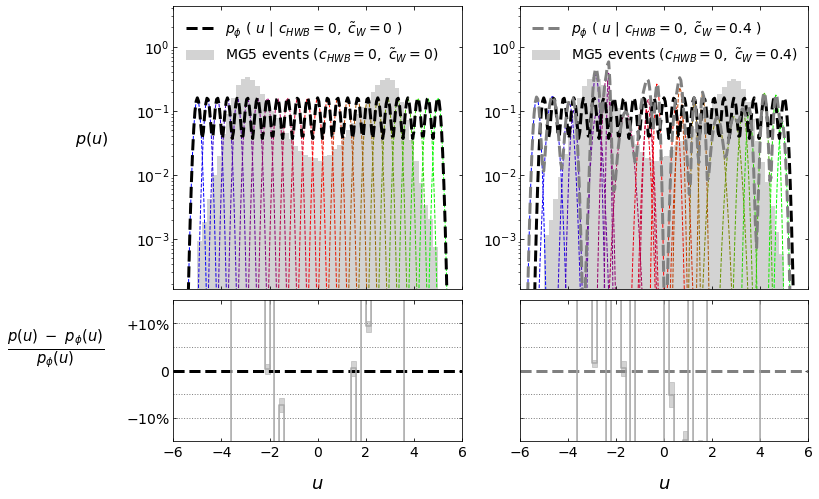

Setting batch size to 100
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 100
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 4
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 1956260 samples, validate on 1956260 samples
Epoch 1/1000
1956260/1956260 [==============================] - 83s 42us/sample - loss: 2.9538e-05 - val_loss: 2.9266e-05
Epoch 2/1000
1956260/1956260 [==============================] - 82s 42us/sample - loss: 2.9260e-05 - val_loss: 2.9241e-05
Epoch 3/1000
1956260/1956260 [======

In [14]:
#  Load model if requested, otherwise build and fit
#

density_model.Gauss_width_reduction_factor = 8.

kernel_init = "glorot_uniform"
bias_init   = "zeros"

for white_meth in whitening_methods :
    #
    #  Load density model if requested
    #
    if (type(white_meth.load_model_dir) != type(None)) and (os.path.exists(white_meth.load_model_dir)) and (load_models) :
        white_meth.density_model = DensityModel.from_dir(white_meth.load_model_dir)
    else :
        #
        #   Figure out the limits of the observables
        #
        range_limits = {}
        for idx in range(num_observables) :
            all_data   = np.concatenate([item[:,idx] for c,item in white_meth.white_data_to_fit.items()])
            imin, imax = np.min(all_data), np.max(all_data)
            irange     = imax - imin
            range_limits[idx] = [imin, imax]
        #
        #   Create density model  
        #
        white_meth.density_model = DensityModel(name            = "EWK_density_model", 
                                                num_gaussians   = output_size_per_stage, 
                                                num_conditions  = 2, 
                                                num_observables = data.get_num_observables(), 
                                                types           = data.types,
                                                int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                                verbose         = True,
                                                learning_rate   = learning_rate,
                                                optimiser       = optimiser,
                                                range_limits    = range_limits,
                                                condition_limits = [[np.min(cHWB_vals ), np.max(cHWB_vals )],
                                                                    [np.min(cWtil_vals), np.max(cWtil_vals)]],
                                                kernel_initializer       = kernel_init,
                                                bias_initializer         = bias_init,
                                                activation               = "leakyrelu",
                                                A1                       = 10   ,
                                                A2                       = 10   ,
                                                B1                       = 10   ,
                                                B2                       = 10   ,
                                                C                        = 1    ,
                                                D2                       = 2    ,
                                                min_gauss_amplitude_frac = 0.   ,
                                                gauss_mean_scale         = 1./8.,
                                                gauss_frac_scale         = 1./8.,
                                                gauss_sigma_scale        = 1./8.,
                                                transform_min            = -2.  ,
                                                transform_max            = 2.   )
        
        #
        #   Rebuild layers if they lead to INF/NaN initial loss for any datapoint
        #

        fit_X = np.concatenate([np.full(fill_value=c, shape=(len(d),2)) for c,d in white_meth.white_data_to_fit.items()])
        fit_Y = np.concatenate([d for c,d in white_meth.white_data_to_fit.items()])
        fit_W = np.concatenate([d for c,d in white_meth.weights_to_fit_2.items()])

        def get_losses (model) :
            losses = model.split_evaluator.predict([fit_X, fit_Y])
            losses = np.multiply(fit_W[:, np.newaxis], losses)
            losses = np.sum(losses, axis=0)
            return losses

        def reset_weights (model) :
            session = tf.compat.v1.keras.backend.get_session()
            for layer in model.layers: 
                if hasattr(layer, "kernel") :
                    layer.kernel.initializer.run(session=session)
                if hasattr(layer, "bias") :
                    layer.bias.initializer.run(session=session)
                    
        attempt, max_attempts = 0, 10
        while attempt < max_attempts :
            print("Evaluating losses")
            start_time = time.time()
            losses = get_losses(white_meth.density_model)
            print(f"-  observable logL are {losses[:-1]}, combined is {losses[-1]}")
            print(f"-  eval completed in {int(time.time() - start_time):.0f}s")
            indices_to_retry = [idx for idx, loss in zip(np.arange(num_observables), losses) if not np.isfinite(loss)]
            if len(indices_to_retry) > 0 :
                print(f"-  rebuilding models for indices {', '.join([f'{idx}' for idx in indices_to_retry])}")
            else :
                attempt = max_attempts
            for idx in indices_to_retry :
                likelihood_model = white_meth.density_model.likelihood_models[idx]
                reset_weights (likelihood_model.model)
            
        #
        #   Plot density model
        #         
        plot_mixture_model(log=True)
                      
        #
        #   Fit density model
        #
        for batch_size in batch_sizes :
            print(f"Setting batch size to {batch_size}")
            white_meth.density_model.fit(white_meth.white_data_to_fit, 
                                         white_meth.weights_to_fit_2,
                                         max_epochs_per_observable = max_epochs,
                                         early_stopping_patience   = early_stopping_patience,
                                         early_stopping_min_delta  = early_stopping_min_delta,
                                         validation_split          = validation_split,
                                         batch_size_per_observable = batch_size)


In [15]:

for white_meth in whitening_methods :
    white_meth.density_model.fit(white_meth.white_data_to_fit, 
                                 white_meth.weights_to_fit_2,
                                 max_epochs_per_observable = 100,
                                 early_stopping_patience   = 1,
                                 validation_split          = -1,
                                 batch_size_per_observable = 10000)
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 100
INFO       DensityModel.fit              -  Training setting: batch_size = 10000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 1
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 3912520 samples
Epoch 1/100
3912520/3912520 [==============================] - 32s 8us/sample - loss: 2.9215e-05
Epoch 2/100
 120000/3912520 [..............................] - ETA: 27s - loss: 2.9234e-05

KeyboardInterrupt: 

In [16]:
#  Save model if requested

for white_meth in whitening_methods :
    if type(white_meth.save_model_dir) != type(None) :
        white_meth.density_model.save_to_dir(white_meth.save_model_dir)
        

fracs [0.00065679 0.00400033 0.02511866 0.05423377 0.07230851 0.07718657
 0.09428826 0.08062246 0.05022571 0.00610246 0.02588216 0.00383471
 0.00933888 0.00676563 0.01567114 0.03654873 0.03848028 0.0521269
 0.09519362 0.10588792 0.07495128 0.0483637  0.01854425 0.00267265
 0.00099458]
means [-4.793121   -4.2265506  -3.7146661  -3.373002   -3.1563907  -2.9002318
 -2.7003722  -2.357057   -1.9070755  -1.4322664  -1.0358405  -0.44319603
  0.01519982  0.4102081   0.9485301   1.5903265   1.9536849   2.2579486
  2.5979908   2.8654962   3.131804    3.4317036   3.7346804   4.219003
  4.6720405 ]
sigmas [0.10418953 0.21195792 0.24370942 0.25610533 0.23195073 0.26327795
 0.30637124 0.36592427 0.378973   0.22617114 0.3960061  0.19874905
 0.26100674 0.24987844 0.32965273 0.41443032 0.35251772 0.32893673
 0.28242493 0.27082178 0.2190855  0.24522643 0.2599187  0.2011604
 0.14063421]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


alt fracs [0.00024013 0.00298598 0.02144474 0.03564496 0.07335171 0.09706529
 0.09975126 0.09277422 0.05751052 0.00483233 0.02045446 0.00162752
 0.00495881 0.00868277 0.01428765 0.04057194 0.03681527 0.04669254
 0.09224736 0.12081162 0.07014871 0.04285422 0.0121886  0.00160303
 0.00045431]
alt means [-4.8331594  -4.161209   -3.535555   -3.3277967  -3.100299   -2.8648298
 -2.702798   -2.4505687  -2.0287106  -1.41967    -0.9765199  -0.553444
 -0.03803371  0.41074178  0.9321166   1.5846251   1.975058    2.2656612
  2.6087692   2.8184905   3.1071665   3.3130054   3.6833801   4.2510014
  4.6279454 ]
alt sigmas [0.13232855 0.30259684 0.39845267 0.39478663 0.30863264 0.40425774
 0.4572682  0.5638489  0.58463764 0.332603   0.70685726 0.3366369
 0.31856155 0.38691437 0.47500446 0.75586295 0.63248134 0.5765251
 0.4655143  0.38669786 0.29384562 0.3817055  0.36054778 0.29800645
 0.17717317]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


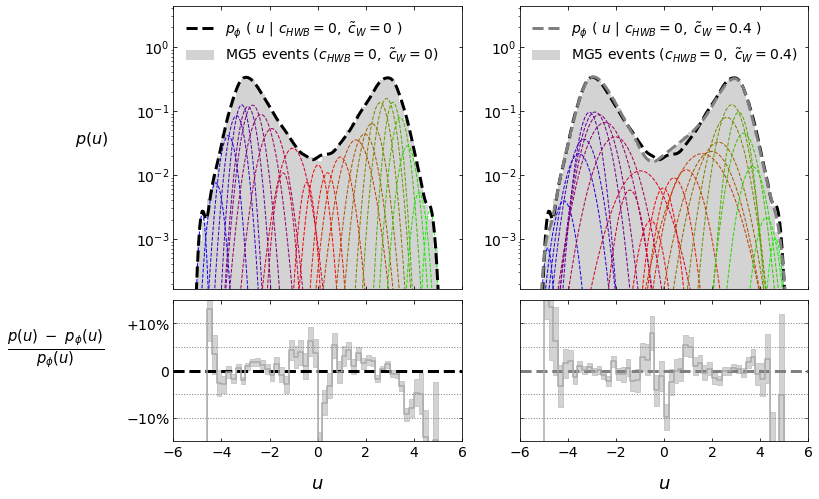

In [17]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

plot_mixture_model(log=True)


In [18]:
#  Parse all pairs of wilson coefficients other than the origin
#

wilson_pairs = []
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        if (cHWB==0.) and (cWtil==0.) : continue
        wilson_pairs.append((cHWB, cWtil))
num_wilson_pairs = len(wilson_pairs)
print(f"{num_wilson_pairs} wilson pairs found")


24 wilson pairs found


In [19]:
#  Generate a large number of datapoints at 0.
#

n_gen = 1000000

print(f"Generating {n_gen} fake datapoints for [cHWB, cWtil] = [0, 0]")
start = time.time()
fake_white_datapoints_SM = white_meth.density_model.sample(n_gen, [0, 0])
end = time.time()
print(f"{n_gen} datapoints generated at (0, 0) in {int(end-start):.0f}s")

fake_white_datapoints = {}
for wilson_pair in wilson_pairs :
    start = time.time()
    fake_white_datapoints [wilson_pair] = white_meth.density_model.sample(n_gen, wilson_pair)
    end = time.time()
    print(f"{n_gen} datapoints evaluated at {wilson_pair} in {(end-start):.2f}s")
    


#  Get density ratios
#

'''fake_datapoint_SM_likelihood = white_meth.density_model.evaluate([0, 0], fake_white_datapoints_SM)

fake_datapoint_weights = {}
for wilson_pair in wilson_pairs :
    start = time.time()
    fake_datapoint_weights [wilson_pair] = white_meth.density_model.evaluate(list(wilson_pair), fake_white_datapoints_SM) / fake_datapoint_SM_likelihood
    end = time.time()
    print(f"{len(fake_white_datapoints_SM)} datapoints evaluated at {wilson_pair} in {(end-start):.2f}s")'''


Generating 1000000 fake datapoints for [cHWB, cWtil] = [0, 0]
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints generated at (0, 0) in 6s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (-4.0, -0.4) in 7.11s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (-4.0, -0.2) in 6.75s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (-4.0, 0.0) in 6.64s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (-4.0, 0.2) in 6.61s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at (-4.0, 0.4) in 6.92s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index i

'fake_datapoint_SM_likelihood = white_meth.density_model.evaluate([0, 0], fake_white_datapoints_SM)\n\nfake_datapoint_weights = {}\nfor wilson_pair in wilson_pairs :\n    start = time.time()\n    fake_datapoint_weights [wilson_pair] = white_meth.density_model.evaluate(list(wilson_pair), fake_white_datapoints_SM) / fake_datapoint_SM_likelihood\n    end = time.time()\n    print(f"{len(fake_white_datapoints_SM)} datapoints evaluated at {wilson_pair} in {(end-start):.2f}s")'

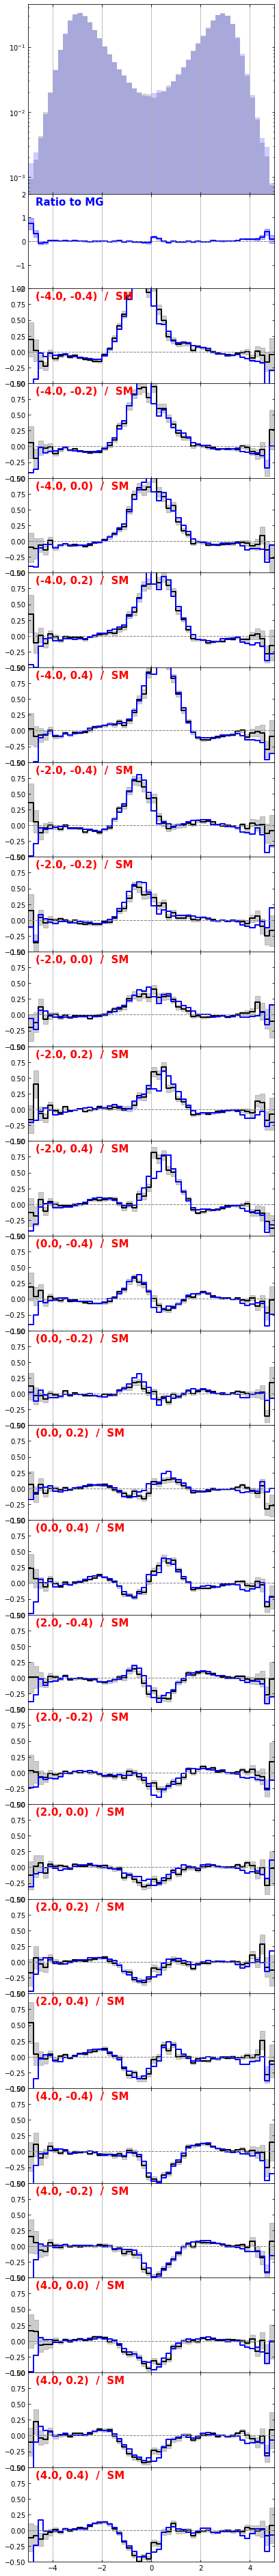

In [21]:

fig = plt.figure(figsize=(5, 2*(2+num_wilson_pairs)))

pad_height = 1. / (3+num_wilson_pairs)
lower      = 1. - 2*pad_height
ax = fig.add_axes([0, lower, 1, 2*pad_height])

bins = np.linspace(-5, 5, 51)
def get_histo (ds, weights=None) :
    if type(weights) == type(None) : weights = np.ones_like(ds)
    weights.reshape(ds.shape)
    bin_entries , _  = np.histogram(ds, weights=weights        , bins=bins)
    bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
    frac_errors      = np.sqrt(bin_variance) / bin_entries
    return bin_entries / np.sum(weights), frac_errors

ds, weights                          = white_meth.white_data_to_fit[(0,0)][:,0], white_meth.weights_to_fit[(0,0)]
bin_entries, frac_errors             = get_histo(ds, weights)
bin_entries_model, frac_errors_model = get_histo(fake_white_datapoints_SM)
ax.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins)
ax.hist(fake_white_datapoints_SM, density=True, color="blue", alpha=0.2, bins=bins)

ax.set_yscale("log")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])

lower = lower - pad_height
ax    = fig.add_axes([0, lower, 1, pad_height]) 
ratio_to_MG       = bin_entries_model / bin_entries
ratio_to_MG_error = ratio_to_MG*np.sqrt(frac_errors*frac_errors + frac_errors_model*frac_errors_model)      
rat_x, rat_y, rat_ey = [], [], []
for idx, b in enumerate(bins) :
    rat_x.append(b)
    if (idx==0) or (idx==len(bins)-1) : continue
    rat_x.append(b)
for y, ey in zip(ratio_to_MG - 1, ratio_to_MG_error) :
    rat_y  .append(y  )
    rat_y  .append(y  )
    rat_ey .append(ey )
    rat_ey .append(ey )
rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)
    
ax.plot(rat_x, rat_y, lw=2, color="b")
ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="b", alpha=0.3)
ax.axhline(0, ls="--", lw=1, c="grey")
ax.text(0.03, 0.97, "Ratio to MG", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="b", weight="bold")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])

for wilson_pair in wilson_pairs :
    lower = lower - pad_height
    ax = fig.add_axes([0, lower, 1, pad_height])
    
    ds, weights = white_meth.white_data_to_fit[wilson_pair][:,0], white_meth.weights_to_fit[wilson_pair]
    this_bin_entries, this_frac_errors = get_histo(ds, weights)
    ratio_to_SM       = this_bin_entries / bin_entries
    ratio_to_SM_error = ratio_to_SM*np.sqrt(frac_errors*frac_errors + this_frac_errors*this_frac_errors)
    
    #this_bin_entries_model, this_frac_errors_model = get_histo(fake_white_datapoints_SM, fake_datapoint_weights[wilson_pair])
    this_bin_entries_model, this_frac_errors_model = get_histo(fake_white_datapoints[wilson_pair])
    ratio_to_SM_model       = this_bin_entries_model / bin_entries_model
    ratio_to_SM_error_model = ratio_to_SM_model*np.sqrt(frac_errors_model*frac_errors_model + this_frac_errors_model*this_frac_errors_model)
    
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = [], [], [], [], []
    for idx, b in enumerate(bins) :
        rat_x.append(b)
        if (idx==0) or (idx==len(bins)-1) : continue
        rat_x.append(b)
    for y, ey, ym, eym in zip(ratio_to_SM - 1, ratio_to_SM_error, ratio_to_SM_model - 1, ratio_to_SM_error_model) :
        rat_y  .append(y  )
        rat_y  .append(y  )
        rat_ey .append(ey )
        rat_ey .append(ey )
        rat_ym .append(ym )
        rat_ym .append(ym )
        rat_eym.append(eym)
        rat_eym.append(eym)
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = np.array(rat_x), np.array(rat_y), np.array(rat_ey), np.array(rat_ym), np.array(rat_eym)
    
    ax.plot(rat_x, rat_y, lw=2, color="k")
    ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="k", alpha=0.2)
    ax.plot(rat_x, rat_ym, lw=2, color="b")
    ax.axhline(0, ls="--", lw=1, c="grey")
    ax.text(0.03, 0.97, f"{wilson_pair}  /  SM", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="r", weight="bold")
    ax.grid(which="both", axis="x")
    ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.5, 1])
        
plt.savefig("density_model_pT_ll_2D.pdf", bbox_inches="tight")
plt.show()


In [ ]:
'''
tmp_model = white_meth.density_model.likelihood_models[0]

p0 = tmp_model.get_gauss_params([[0, 0.0]])[0]
p1 = tmp_model.get_gauss_params([[0, 0.4]])[0]

for pp0, pp1 in zip(p0, p1) :
    print(f"{pp0:.4f}, {pp1:.4f}, {pp1/pp0:.4f}")'''

In [ ]:
'''import tensorflow as tf

# Here goes the neural network weights as tf.Variable
x = tf.Variable(3.0)

# TensorFlow operations executed within the context of
# a GradientTape are  recorded for differentiation 
with tf.GradientTape() as tape:
  # Doing the computation in the context of the gradient tape
  # For example computing loss
  y = x ** 2 

# Getting the gradient of network weights w.r.t. loss
dy_dx = tape.gradient(y, x) 
print(dy_dx)  # Returns 6'''

In [ ]:
'''
A, leakyness = 5., 0.2
weights = np.array([A, -A])

def pass_fwd (x) :
    inputs      = weights * x
    activations = inputs[inputs>0] + leakyness*inputs[inputs<0]
    activations = activations / A / (1-leakyness)
    return np.sum(activations)

for val in np.random.uniform(20, size=(10,)) - 10. :
    print(f"{val:.3f}".ljust(7)+f" -->  {pass_fwd(val):.3f}")
    '''